# Helpers

In [0]:
import os, sys, wave, struct

import numpy as np
import matplotlib.pyplot as plt
#import pyaudio
import pandas as pd

from copy import deepcopy
from math import ceil
from scipy.io import wavfile

In [0]:
def load_music(file):
    return wave.open(file, 'rb')

def play_music(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_music(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
def process_sound(music) :
    '''
    Process Sound
    '''
    wavefile = load_music(music)
    param = wavefile.getparams()

    Fs, data = wavfile.read(music)
    timestep = 1/float(Fs)
    times = np.arange(len(data))*timestep

    return Fs, data, times, param
  
def write_music_1D(file, param, data):
    '''
    Write Music in wav file (mono)
    '''
    wavefile = wave.open(file, 'wb')
    wavefile.setparams(param)
    wavefile.setnframes(len(data))
    wavefile.setnchannels(1)

    for i in range(len(data)):
        v = int(data[i])
        wavefile.writeframesraw( struct.pack('<h', v ) )
    wavefile.writeframes(''.encode())
    wavefile.close()

# 3 - Synthetic signal

## 3.1 Spectral analysis by Fourier transform

In [0]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s 
  
N = 63
delta = np.array([0,-0.05])
f = np.array([1./4,1./4 + 1./N])
a = np.array([1,10])
phi = np.array([1,2])
x = Synthesis(N,delta,f,a,phi)

In [0]:
def plot_periodogram(x,N=None):
  
  if N==None:
    N = len(x)
  ft = np.fft.fft(x,N)
  ft = np.abs(ft)
  plt.plot(ft)
  plt.title('Periodogram')
  plt.show()

#### No zero-padding

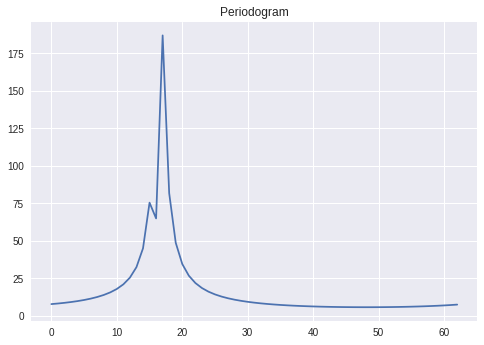

In [6]:
plot_periodogram(x)

#### Zero padding

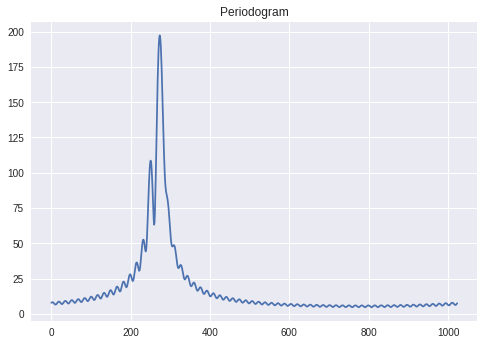

In [7]:
plot_periodogram(x,N=1024)

Adding zero-padding results in more spikes in the periodogram, making the 2 spikes more visible but also adding smaller superfluous spikes.

## 3.2 High resolution methods

### 3.2.1 ESPRIT method

In [0]:
from numpy.linalg import svd, pinv, eig

def ESPRIT(x,n,K):
  
  N = len(x)
  l = N - n + 1
  
  # compute X and R_x,x
  X = np.matrix([ [ x[nn + ll] for nn in range(n) ] for ll in range(l)])
  R_xx = (1./l)*np.matmul(X,X.H)
  
  # create W matrix
  U1,diag,U2 = svd(R_xx)
  W = U1[:,:K]
  
  # extract W_up, W_down
  W_down = W[:-1,:]
  W_up = W[1:,:]
  
  # compute Phi and its eigenvalues
  Phi = np.matmul( pinv(W_down), W_up )
  z, eigenvectors = eig(Phi)
  
  #compute delta and f
  delta = np.log(np.abs(z))
  f = np.angle(z)/(2.*np.pi)
  
  return delta,f

In [0]:
def LeastSquares(x,delta,f,n,K):
  
  #compute V^N using the log
  N = len(x)
  column = delta + 2j*np.pi*f
  row = range(N)
  V = np.exp(np.outer(row,column))
  
  # compute alpha, a and phi
  alpha = np.dot(pinv(V),x)
  a = np.abs(alpha)
  phi = np.angle(alpha)
  
  return a, phi

#### 5. Application to synthetic signals

In [10]:
n = 32  
K = 3
delta_estim,f_estim = ESPRIT(x,n,K)

print(f' Estimation of delta: {np.round(delta_estim,10)}, real value of delta: {delta}')
print(f' Estimation of f: {np.round(f_estim,10)}, real value of f: {f}')

a_estim, phi_estim = LeastSquares(x,delta_estim,f_estim,n,K)

print(f' Estimation of a: {np.round(a_estim,10)}, real value of delta: {a}')
print(f' Estimation of phi: {np.round(phi_estim,10)}, real value of f: {phi}')


 Estimation of delta: [-0.05       -0.         -1.65952358], real value of delta: [ 0.   -0.05]
 Estimation of f: [ 0.26587302  0.25       -0.33464714], real value of f: [0.25       0.26587302]
 Estimation of a: [10.  1.  0.], real value of delta: [ 1 10]
 Estimation of phi: [2.         1.         1.68773997], real value of f: [1 2]


The result is perfect, the original parameters are precisely computed.

### 3.2.2 MUSIC method

#### 6. MUSIC pseudo-spectrum

In [0]:
def get_spectrum(delta,f,W_ortho,n):
  
  z = np.exp(delta + 2j*np.pi*f)
  nu = np.array([ z**nn for nn in range(n) ])
  spectrum = 1./( np.linalg.norm( np.dot(W_ortho.H,nu) )**2 )
  
  return spectrum

def MUSIC(x,n,K,Delta,F):
  
  ######################################
  ## Start like ESPRIT to get W_ortho ##
  
  N = len(x)
  l = N - n + 1
  
  # compute X and R_x,x
  X = np.matrix([ [ x[nn + ll] for nn in range(n) ] for ll in range(l)])
  R_xx = (1./l)*np.dot(X,X.H)
  
  # create W matrix
  U1,diag,U2 = svd(R_xx)
  W_ortho = U1[:,K:]
  
  ######################################
  
  P = np.array([ [ np.log(get_spectrum(d,f,W_ortho,n)) for d in Delta ] for f in F ])
  plt.contour(Delta, F, P, 30, cmap='inferno')
  plt.colorbar()

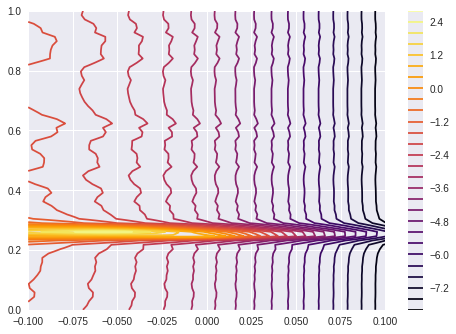

In [12]:
Delta = np.linspace(-0.1,0.1,70)
F = np.linspace(0,1,70)
  
MUSIC(x,n,K,Delta,F)

On trouve les deux pics en zoomant: 

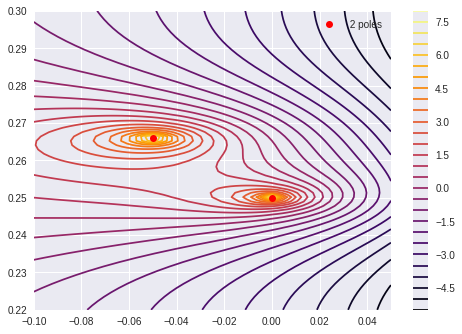

In [13]:
Delta = np.linspace(-0.1,0.05,70)
F = np.linspace(0.22,0.3,70)
  
plt.plot(delta,f,'ro', label = ' 2 poles')  
plt.legend()
MUSIC(x,n,K,Delta,F)

# 4 Audio signals

## 4.1 Spectral analysis by Fourier transform

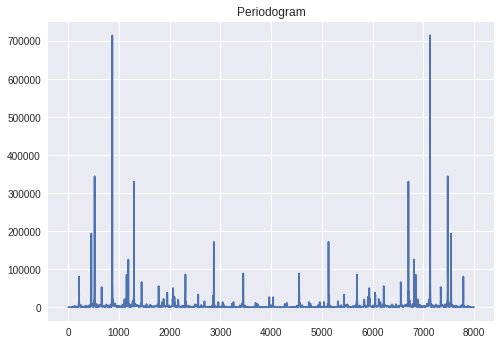

In [14]:
bell = load_music('ClocheA.WAV')

Fs, data, times, param = process_sound('ClocheA.WAV')

plot_periodogram(data,Fs)

### 4.2 High resolution method

In [0]:
K = 54
n = 512
l = 2*n
N = n + l - 1
x = data[10000:10000+N]

delta_bell, f_bell = ESPRIT(x,n,K)
a_bell, phi_bell = LeastSquares(x,delta_bell,f_bell,n,K)
x_synth = Synthesis(N,delta_bell,f_bell,a_bell,phi_bell)

wavfile.write('synthesised_Bell.wav',Fs,np.abs(x_synth)*np.angle(x_synth) )



Malgres beaucoup d'efforts je n'ai pas reussi a reproduire le son voulu !

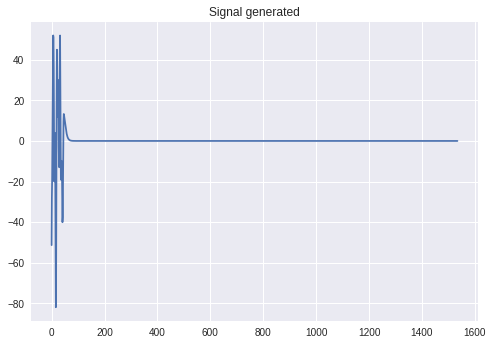

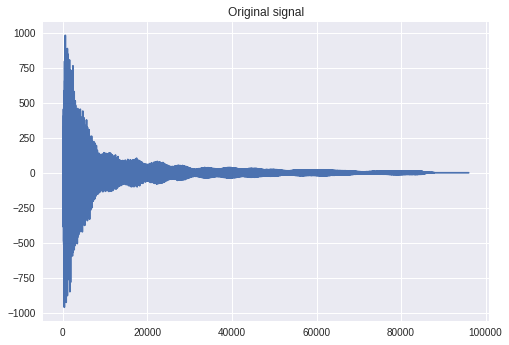

In [16]:
plt.plot(x_synth.real)
plt.title('Signal generated')
plt.show()
plt.plot(data.real)
plt.title('Original signal')
plt.show()

In [29]:
def get_W(x,n,K):
    
  N = len(x)
  l = N - n + 1

  # compute X and R_x,x
  X = np.matrix([ [ x[nn + ll] for nn in range(n) ] for ll in range(l)])
  R_xx = (1./l)*np.matmul(X,X.H)

  # create W matrix
  U1,diag,U2 = svd(R_xx)
  W = U1[:,:K]

  return np.matrix(W)

def ESPRIT_2(x,n,K):
  
  N = len(x)
  l = N - n + 1
  
  # compute X and R_x,x
  X = np.matrix([ [ x[nn + ll] for nn in range(n) ] for ll in range(l)])
  R_xx = (1./l)*np.matmul(X,X.H)
  
  # create W matrix
  U1,diag,U2 = svd(R_xx)
  W = U1[:,:K]
  
  return W

def get_W(x,n,M):
  
  N = len(x)
  l = N - n + 1
  
  # compute X and C_x,x
  X = np.matrix([ [ x[nn + ll] for nn in range(n) ] for ll in range(l)])
  C_xx = (1./l)*np.matmul(X,X.H)
  
  # create W matrix
  U1,diag,U2 = svd(C_xx)
  W = U1[:,:M]
  
  return W

M = 54
n = 512
l = 2*n
N = n + l - 1
x = data[10000:10000+N]
  
W = get_W(x,n,M)
W = np.matrix(W)
print(W.shape)
print('got W')
Ps = np.dot(W,W.H)
M,M = Ps.shape
x = data[10000:10000+2*n]
s_h = np.dot(Ps,x)
s_n = np.dot(np.eye(M),x)



(1024, 54)
got W


In [30]:
Audio(s_h,rate = Fs)

NameError: ignored